In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats
from tqdm import tqdm

import sys 
sys.path.append("..")

from src.models import ContextSpaceNet, RecurrentSpaceNet, Decoder, End2End
from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker

#### Feedforward network

In [2]:
train_steps = 5000
n_in = 3        # 2 position + 1 context
n_out = 100     # no. of spatial representations
bs = 128        # batch size

# Initialize model and optimizer
model = ContextSpaceNet(n_in, n_out, scale=0.1, lam=10)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Generate random positions
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32)
    c = torch.tensor(np.random.uniform(-1, 1, bs), dtype = torch.float32)[:, None]

    # Concatenate position and context
    inputs = torch.cat((r, c), dim = -1)
    labels = (r, c)     # Labels are provided as a tuple

    # Train step
    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

loss: 0.124521: 100%|██████████| 5000/5000 [00:05<00:00, 849.63it/s]


Text(0, 0.5, 'Train Loss')

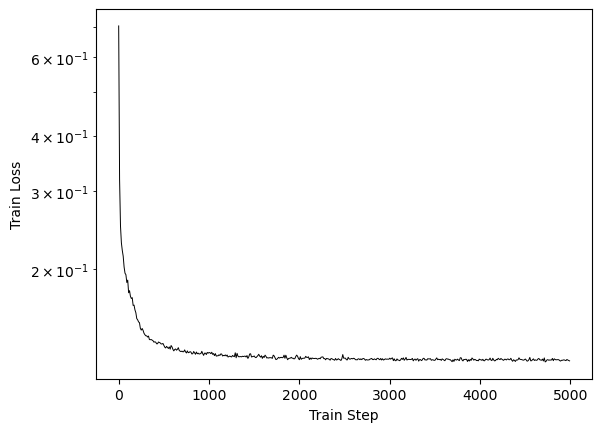

In [3]:
plt.semilogy(np.arange(0, train_steps, 10), loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [4]:
# Evaluate on 2x2 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x, y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=-1), dtype=torch.float32)

In [5]:
sig_c = 0.25

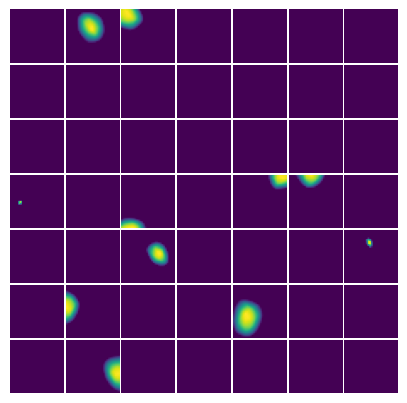

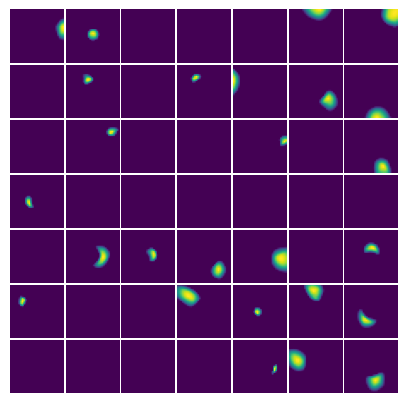

In [6]:
for context in (torch.ones((n**2)), np.exp(-0.5/sig_c**2*((u[:, 0] - 0)**2 + (u[:, 1] - 0)**2))):

    # Create input
    inputs = torch.cat((u, context[...,None]), dim = -1)

    # Get spatial representations
    p = model.spatial_representation(inputs)
    p = p.detach().numpy()
    # Todo not sure why I have to swap axes here
    p = np.swapaxes(p.T.reshape(-1, n, n), 2, 1) # reshape to (n_out, n, n)

    # Plot ratemaps
    fig, ax = ratemap_collage(p[:49], cols=7, figsize=(5, 5))
    plt.subplots_adjust(wspace=0.05, hspace=0.01)
    # plt.savefig("figures/bipartite_context")

In [7]:
train_steps = 5000
n_in = 1        # 2 position + 1 context
n_out = 100     # no. of spatial representations
bs = 128        # batch size

# Initialize model and optimizer
model = ContextSpaceNet(n_in, n_out, scale=0.1, lam=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Generate random positions
    c = torch.tensor(np.random.uniform(-1, 1, bs), dtype = torch.float32)[:, None]

    # Concatenate position and context
    inputs = c
    labels = (c,)     # Labels are provided as a tuple

    # Train step
    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.017239: 100%|██████████| 5000/5000 [00:05<00:00, 964.62it/s]


In [8]:
contexts = [np.exp(-0.5/sig_c**2*((u[:, 0] - 0)**2 + (u[:, 1] - 0)**2)) ]

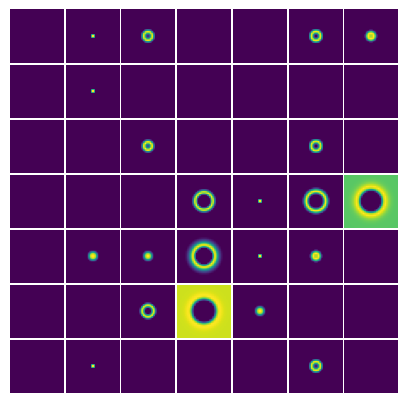

In [9]:
for context in contexts:

    # Create input
    inputs = context[...,None]
    # Get spatial representations
    p = model.spatial_representation(inputs)
    p = p.detach().numpy()
    # Todo not sure why I have to swap axes here
    p = np.swapaxes(p.T.reshape(-1, n, n), 2, 1) # reshape to (n_out, n, n)

    # Plot ratemaps
    fig, ax = ratemap_collage(p[:49], cols=7, figsize=(5, 5))
    plt.subplots_adjust(wspace=0.05, hspace=0.01)
    # plt.savefig("figures/bipartite_context")

In [10]:
## Add no-context-masking

In [11]:


class Obsnet(torch.nn.Module):
    """Feedforward SpaceNet model with a single hidden layer."""

    def __init__(self, n_in, n_out, lam = 0, scale = 1, **kwargs):
        super(Obsnet, self).__init__(**kwargs)
        self.spatial_representation = torch.nn.Sequential(
            torch.nn.Linear(n_in, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, n_out),
            torch.nn.ReLU()
        )
        self.lam = lam
        self.scale = scale
        self.device = "cpu"
        self.to(self.device)
        
    def forward(self, inputs, **kwargs):
        p = self.spatial_representation(inputs)  # ns, nr
        dp = torch.pdist(p)**2
        corr = torch.exp(-dp)
        return corr, p

    def correlation_function(self, r):        
        dr = torch.nn.functional.pdist(r)**2
        correlation = torch.exp(-0.5 / self.scale**2 * dr)
        return correlation


    def train_step(self, x, y, optimizer):
        """Perform a single training step and returns the loss.
        """
        optimizer.zero_grad()
        loss = self.loss_fn(x, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    
    def loss_fn(self, x, ys, mask = None, **kwargs):
        """Loss function

        Args:
            x: Torch tensor of shape (batch size, 3). The function assumes
            that the first two components are spatial coordinates, while
            the last is a context coordinate.
            ys:  A tuple of tensors.

        Returns:
            loss (1D tensor)
        """
        # Get output of the model, which is the correlations (corr)
        # and the spatial representation (p)
        corr, p = self.forward(x)
        
        # Iterate over all ys. In case of context, ys is a tuple of tensors, and
        # the correlation function is computed both spatially, and for the context.
        labels = torch.ones_like(corr)
        for y in ys:
            labels *= self.correlation_function(y)

        loss = torch.mean((corr - labels)**2)

        # Add regularization term
        total_loss = loss + self.lam*torch.mean(p**2)

        return total_loss


In [12]:
train_steps = 5000
n_in = 1        # 2 position + 1 context
n_out = 100     # no. of spatial representations
bs = 128        # batch size

# Initialize model and optimizer
model = Obsnet(n_in, n_out, scale=0.25, lam=1)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress:

    # Generate random positions
    c = torch.tensor(np.random.uniform(-1, 1, bs), dtype = torch.float32)[:, None]

    # Concatenate position and context
    inputs = c
    labels = (c,)     # Labels are provided as a tuple

    # Train step
    loss = model.train_step(x=inputs, y=labels, optimizer=optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.015885: 100%|██████████| 5000/5000 [00:05<00:00, 938.92it/s] 


/Users/m/Documents/jobb/phd/BSR/remapping_experiments/../src/utils.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(cols, rows, figsize = figsize, **kwargs)


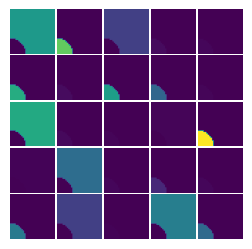

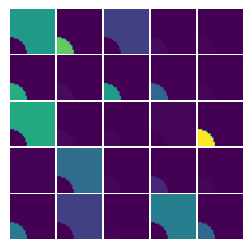

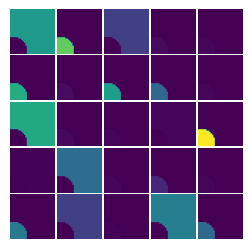

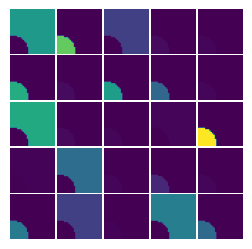

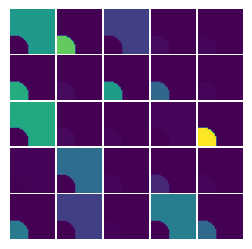

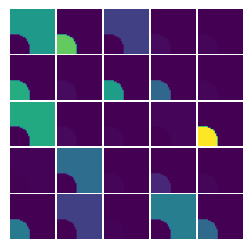

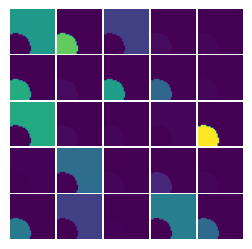

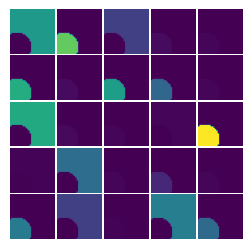

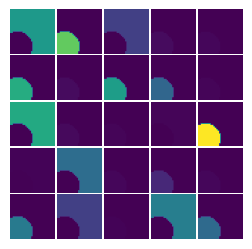

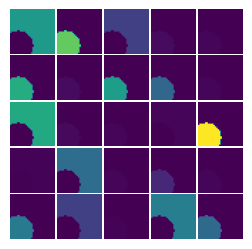

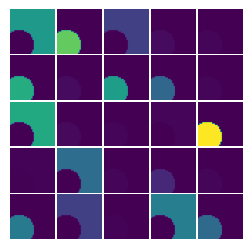

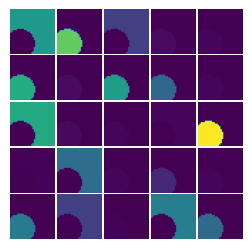

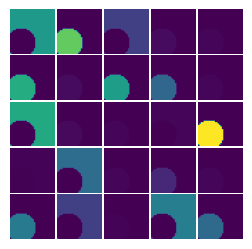

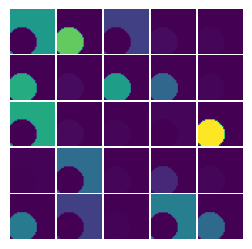

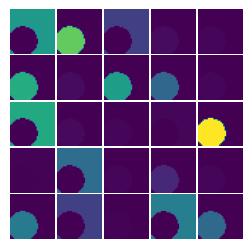

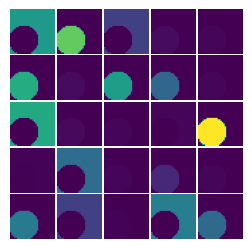

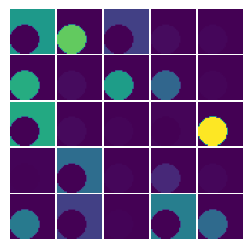

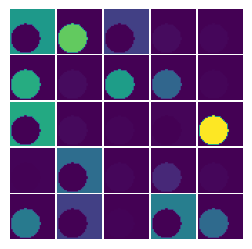

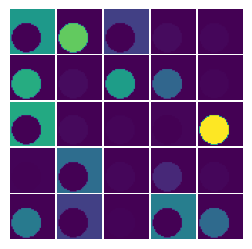

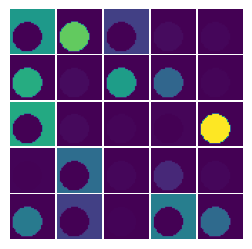

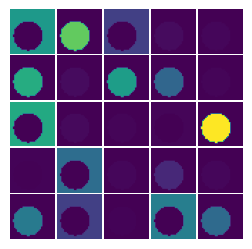

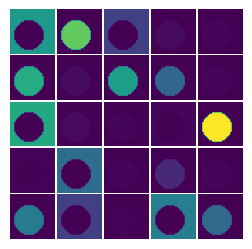

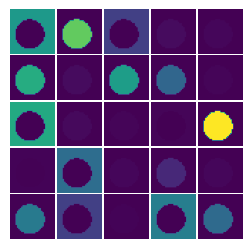

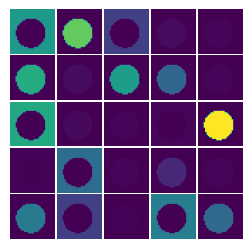

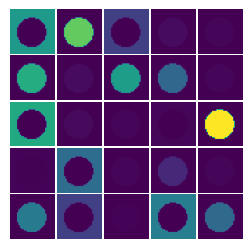

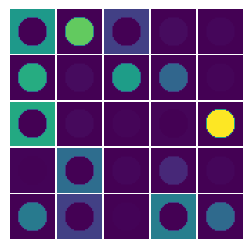

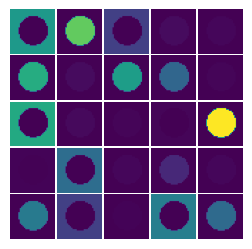

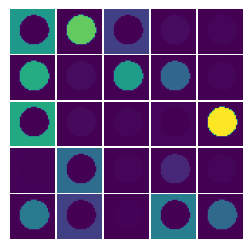

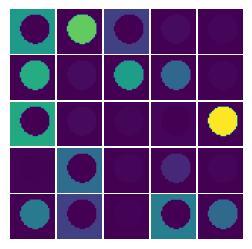

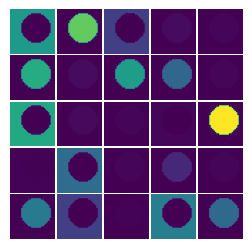

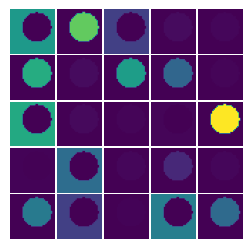

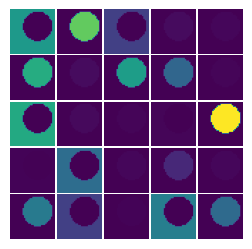

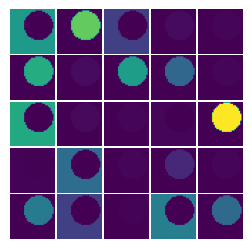

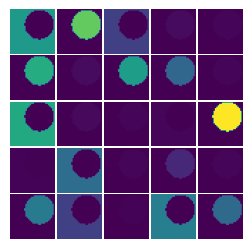

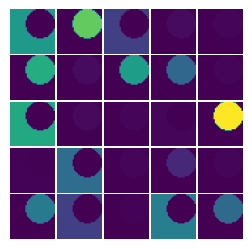

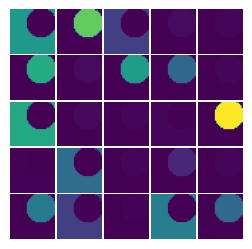

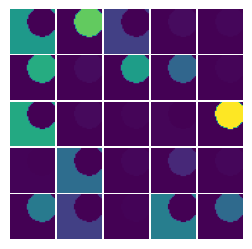

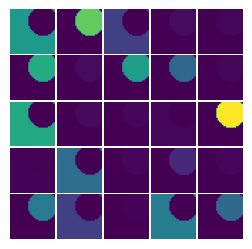

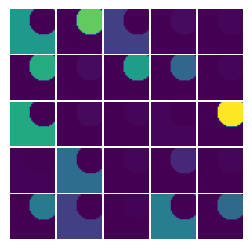

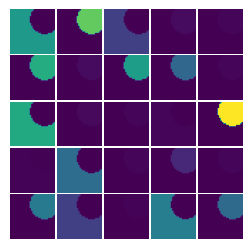

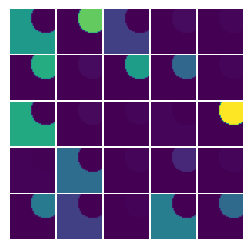

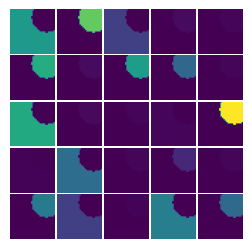

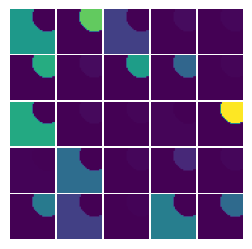

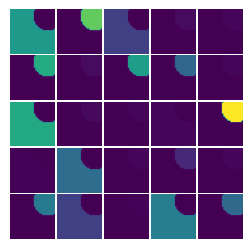

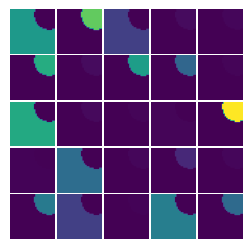

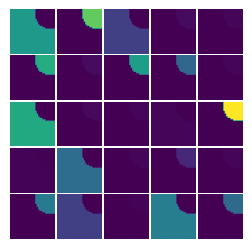

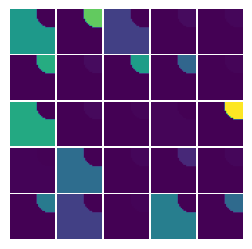

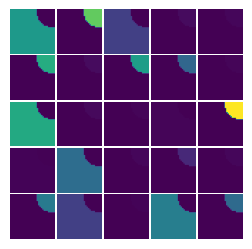

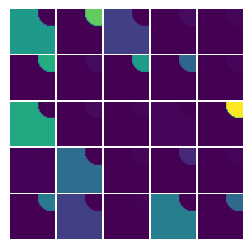

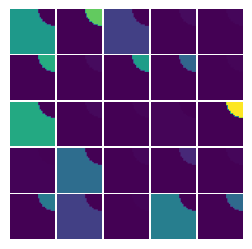

In [36]:
sig_c = 0.5
contexts = [(np.exp(-0.5/sig_c**2*((u[:, 0]+ 1 - i/25)**2 + (u[:, 1]+ 1 - i/25)**2)) > 0.4)*1.0 for i in range(50)]
# contexts = [(torch.sum(u**2,axis=-1) < 0.25)*0.5]

for i, context in enumerate(contexts):

    # Create input
    inputs = context[...,None]
    # Get spatial representations
    p = model.spatial_representation(inputs)
    p = p.detach().numpy()

    p = np.swapaxes(p.T.reshape(-1, n, n), 2, 1) # reshape to (n_out, n, n)
    mask = np.amax(p, axis = (1, 2)) > 0
    # Plot ratemaps
    fig, ax = ratemap_collage(p[mask][:25], cols=5, figsize=(3, 3), normalize= True)
    plt.subplots_adjust(wspace=0.05, hspace=0.01)
    plt.savefig(f"../figures/anim/frame_{i+1:04d}.png")

In [14]:
contexts[0].shape

torch.Size([1024])

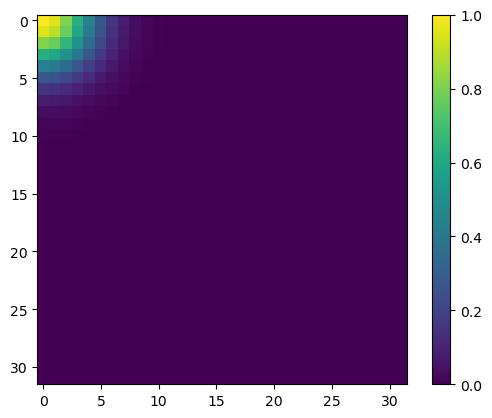

In [15]:
plt.imshow(contexts[0].reshape(32,32))
plt.colorbar()